In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from io import StringIO
from itertools import combinations

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.base import clone
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [2]:
csv_data = \
'''
    A,B,C,D
    1.0, 2.0, 3.0, 4.0
    5.0, 6.0,, 8.0
    10.0, 11.0, 12.0
'''
df = pd.read_csv(StringIO(csv_data))

In [3]:
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [4]:
df.isnull().sum()

    A    0
B        0
C        1
D        1
dtype: int64

In [5]:
df.dropna(axis=0)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [6]:
df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


In [7]:
# Only drops rows where all columns are Nan
# Returns the whole array since we don't have a row with all values NaN
df.dropna(how = "all")

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [8]:
# Drop rows that have fewer than 4 real values 
df.dropna(thresh = 4)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [9]:
# Only drops rows where NaN appear in specific columns (here: 'C')
df.dropna(subset = ['C'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


In [10]:
imr = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

In [11]:
df.fillna(df.mean())

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,7.5,8.0
2,10.0,11.0,12.0,6.0


In [12]:
df = pd.DataFrame([
    ['green','M','10.1','class2'],
    ['red','L','13.5','class1'],
    ['blue','XL','15.3','class2']])
df.columns = ['color','size','price','classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


In [13]:
size_mapping = {'XL':3,'L':2,'M':1}
df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


In [14]:
inv_size_mapping = {v:k for k, v in size_mapping.items()}
df['size'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

In [15]:
class_mapping = {label: idx for idx, label in enumerate(np.unique(df['classlabel']))}
class_mapping

{'class1': 0, 'class2': 1}

In [16]:
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,1
1,red,2,13.5,0
2,blue,3,15.3,1


In [17]:
inv_class_mapping = {v: k for k, v in class_mapping.items()}
df['classlabel'] = df['classlabel'].map(inv_class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


In [18]:
class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y

array([1, 0, 1])

In [19]:
class_le.inverse_transform(y)

array(['class2', 'class1', 'class2'], dtype=object)

In [20]:
X = df[['color','size','price']].values
color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])
X

array([[1, 1, '10.1'],
       [2, 2, '13.5'],
       [0, 3, '15.3']], dtype=object)

In [21]:
X = df[['color','size','price']].values
color_ohe = OneHotEncoder()
color_ohe.fit_transform(X[:,0].reshape(-1, 1)).toarray()

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [22]:
X = df[['color','size','price']].values
c_transf = ColumnTransformer([
    ('onehot', OneHotEncoder(), [0]),
    ('nothing', 'passthrough', [1,2])
])
c_transf.fit_transform(X).astype(float)

array([[ 0. ,  1. ,  0. ,  1. , 10.1],
       [ 0. ,  0. ,  1. ,  2. , 13.5],
       [ 1. ,  0. ,  0. ,  3. , 15.3]])

In [23]:
pd.get_dummies(df[['price','color','size']])

,size,price_10.1,price_13.5,price_15.3,color_blue,color_green,color_red
0,1,True,False,False,False,True,False
1,2,False,True,False,False,False,True
2,3,False,False,True,True,False,False


In [24]:
pd.get_dummies(df[['price','color','size']], drop_first= True)

,size,price_13.5,price_15.3,color_green,color_red
0,1,False,False,True,False
1,2,True,False,False,True
2,3,False,True,False,False


In [25]:
color_ohe = OneHotEncoder(categories = 'auto', drop = 'first')
c_transf = ColumnTransformer([
    ('onehot', color_ohe, [0]),
    ('nothing', 'passthrough', [1,2])
])
c_transf.fit_transform(X).astype(float)

array([[ 1. ,  0. ,  1. , 10.1],
       [ 0. ,  1. ,  2. , 13.5],
       [ 0. ,  0. ,  3. , 15.3]])

In [26]:
df = pd.DataFrame([['green','M',10.1,'class2'],
                   ['red','L',13.5,'class1'],
                   ['blue','XL',15.3,'class2']])
df.columns = ['color','size','price','classlabel']
df             

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


In [27]:
df['x > M'] = df['size'].apply(
    lambda x: 1 if x in {'L','XL'} else 0)
df['x > L'] = df['size'].apply(
    lambda x: 1 if x == 'XL' else 0)
del df['size']
df

,color,price,classlabel,x > M,x > L
0,green,10.1,class2,0,0
1,red,13.5,class1,1,0
2,blue,15.3,class2,1,1


In [28]:
df_wine = pd.read_csv('wine.data', header = None)
df_wine.columns = ['Class label', 'Alcohol','Malic acid','Ash','Alcalinity of ash','Magnesium','Total phenols','Flavnoids','Nonflavnoid phenols','Proanthocyanins','Color Intensity','Hue','OD280/OD315 of diluted values','Proline']
print('Class labels', np.unique(df_wine['Class label']))

Class labels [1 2 3]


In [29]:
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavnoids,Nonflavnoid phenols,Proanthocyanins,Color Intensity,Hue,OD280/OD315 of diluted values,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [30]:
X, y = df_wine.iloc[:,1:].values, df_wine.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify = y)

In [31]:
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

In [32]:
ex = np.array([0,1,2,3,4,5,])
print('standarized:', (ex - ex.mean()) / ex.std())

standarized: [-1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011]


In [33]:
print('normalized:', (ex - ex.mean()) / (ex.max() - ex.min()))

normalized: [-0.5 -0.3 -0.1  0.1  0.3  0.5]


In [34]:
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [35]:
LogisticRegression(penalty = 'l1', solver = 'liblinear', multi_class = 'ovr')

LogisticRegression(multi_class='ovr', penalty='l1', solver='liblinear')

In [36]:
lr = LogisticRegression(penalty = 'l1', C = 1.0, solver = 'liblinear', multi_class = 'ovr')
# Note that C = 1.0 is the default. You can increase or decrease it to make the regularization effect stronger or weaker, respectively
lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))

Training accuracy: 1.0


In [37]:
lr.intercept_

array([-1.2631861 , -1.21581424, -2.37008498])

In [38]:
lr.coef_

array([[ 1.24601239,  0.18122603,  0.7426661 , -1.16016356,  0.        ,
         0.        ,  1.17512881,  0.        ,  0.        ,  0.        ,
         0.        ,  0.54163608,  2.51113401],
       [-1.53680459, -0.38720814, -0.99519635,  0.36494592, -0.05971504,
         0.        ,  0.66840758,  0.        ,  0.        , -1.93421482,
         1.23334004,  0.        , -2.23146484],
       [ 0.13538163,  0.16967286,  0.35772482,  0.        ,  0.        ,
         0.        , -2.43371319,  0.        ,  0.        ,  1.56220263,
        -0.81864022, -0.49553346,  0.        ]])

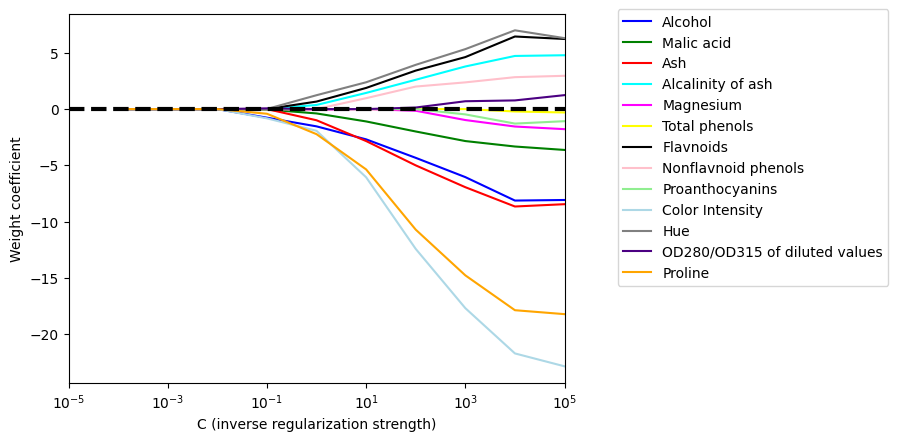

In [39]:
fig = plt.figure()
ax = plt.subplot(111)
colors = ['blue','green','red','cyan','magenta','yellow','black','pink','lightgreen','lightblue','gray','indigo','orange']
weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(penalty = 'l1', C = 10.**c, solver = 'liblinear', multi_class= 'ovr', random_state = 0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)
weights = np.array(weights)
for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:,column], label = df_wine.columns[column  + 1], color = color)
plt.axhline(0, color = 'black', linestyle = '--', linewidth = 3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('Weight coefficient')
plt.xlabel('C (inverse regularization strength)')
plt.xscale('log')
plt.legend(loc = 'upper left')
ax.legend(loc = 'upper center', bbox_to_anchor = (1.38, 1.03), ncol = 1, fancybox = True)
plt.show()

In [40]:
class SBS:
    def __init__(self, estimator, k_features, scoring = accuracy_score, test_size = 0.25, random_state = 1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = self.test_size, random_state = self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]
        while dim > self.k_features:
            scores = []
            subsets = []
            for p in combinations(self.indices_, r = dim - 1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        return self
    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [41]:
knn = KNeighborsClassifier(n_neighbors = 5)
sbs = SBS(knn, k_features = 1)
sbs.fit(X_train_std, y_train)

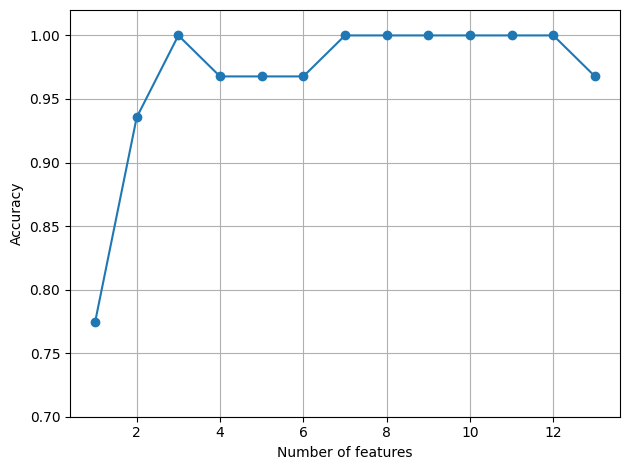

In [42]:
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker = 'o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

In [43]:
k3 = list(sbs.subsets_[10])
print(df_wine.columns[1:][k3])

Index(['Alcohol', 'Malic acid', 'OD280/OD315 of diluted values'], dtype='object')


In [44]:
knn.fit(X_train_std, y_train)
print("Training accuracy:", knn.score(X_train_std, y_train))
print("Testing accuracy:", knn.score(X_test_std, y_test))

Training accuracy: 0.967741935483871
Testing accuracy: 0.9629629629629629


In [45]:
knn.fit(X_train_std[:,k3], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k3], y_train))
print('Testing accuracy:', knn.score(X_test_std[:, k3], y_test))

Training accuracy: 0.9516129032258065
Testing accuracy: 0.9259259259259259


 1) Ash                            0.013279
 2) Nonflavnoid phenols            0.013354
 3) Alcalinity of ash              0.022366
 4) Proanthocyanins                0.025570
 5) Malic acid                     0.025648
 6) Magnesium                      0.031357
 7) Total phenols                  0.050872
 8) Hue                            0.058739
 9) Alcohol                        0.118529
10) OD280/OD315 of diluted values  0.136162
11) Color Intensity                0.143920
12) Flavnoids                      0.174751
13) Proline                        0.185453


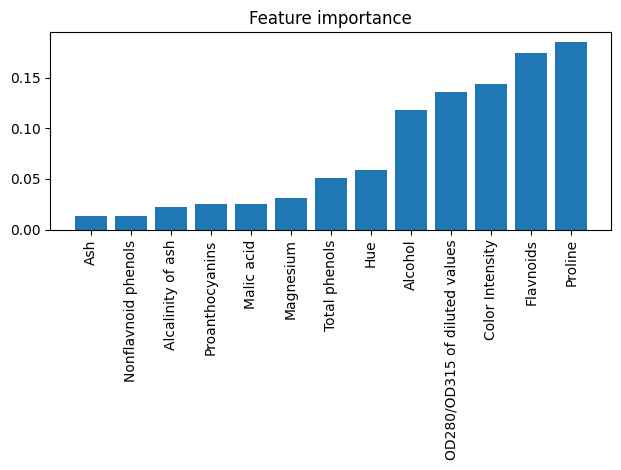

In [54]:
feat_labels = df_wine.columns[1:]
forest = RandomForestClassifier(n_estimators = 500, random_state = 1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_ 
indices = np.argsort(importances)
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))
plt.title('Feature importance')
plt.bar(range(X_train.shape[1]), importances[indices], align = 'center')
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation = 90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [59]:
sfm = SelectFromModel(forest, threshold = 0.1, prefit = True)
X_selected = sfm.transform(X_train)
print('Number of features that meet this threshold', 'criterion', X_selected.shape[1])
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

Number of features that meet this threshold criterion 5
 1) Ash                            0.013279
 2) Nonflavnoid phenols            0.013354
 3) Alcalinity of ash              0.022366
 4) Proanthocyanins                0.025570
 5) Malic acid                     0.025648
